In [2]:
import sys  
sys.path.insert(1, '/Users/simon/Documents/II/Dissertation/')
%load_ext autoreload
%autoreload 2
from src.misc import load_processed_dataset, evaluate
import torch
import numpy as np
import pandas as pd
import yaml
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
load_processed_dataset("jpm", "2019-01-1", "2024-01-1").columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'log_return',
       'log_return_open', 'log_return_high', 'log_return_low',
       'log_return_volume', 'log_return_forecast', 'sma', 'wma', 'ema', 'dema',
       'tema', 'aroon', 'rsi', 'willr', 'cci', 'ad', 'mom', 'slowk', 'slowd',
       'macd', 'fed_funds_rate', '^N225', '^IXIC', '^FTSE', '^SPX', '^DJI'],
      dtype='object')

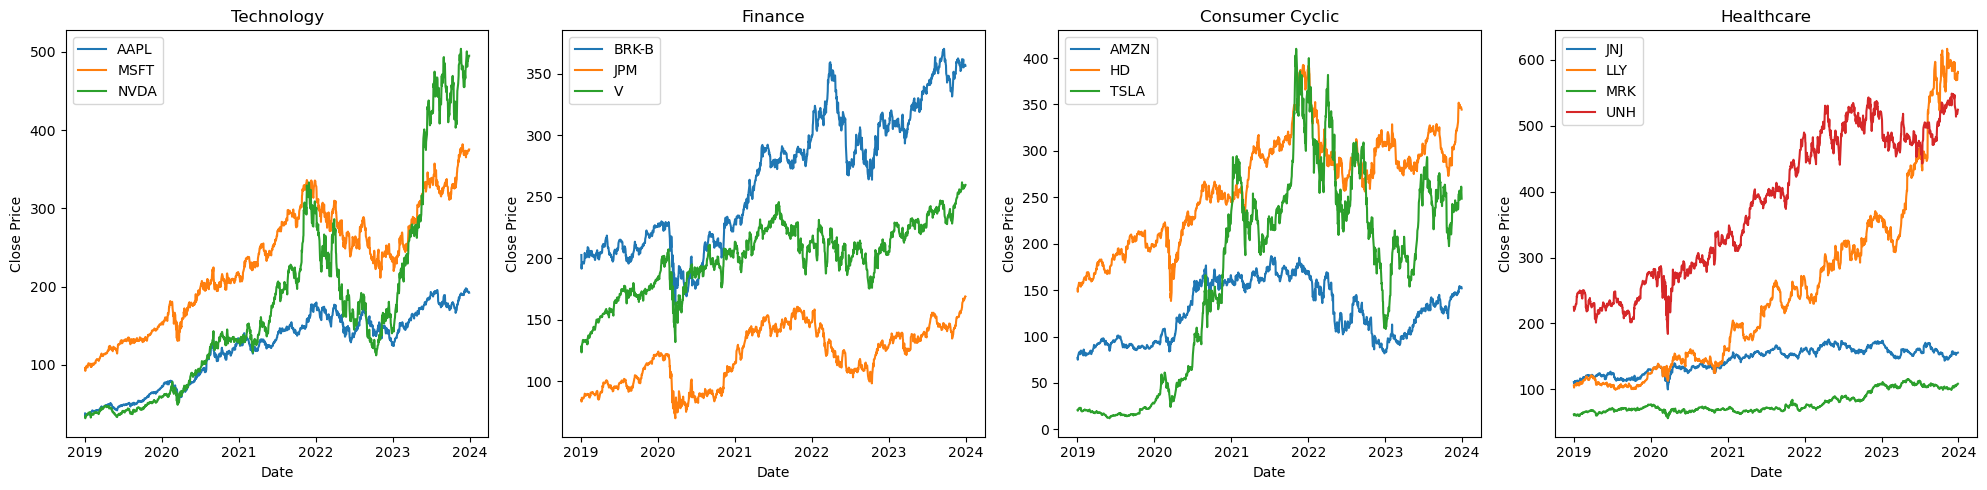

In [6]:
all_stocks = ["aapl", "amzn", "avgo", "brk-b", "cost", "hd", "jnj", "jpm", "lly", "ma", "meta", "mrk", "msft", "nvda", "pg", "tsla", "unh", "v", "xom"]
sectors = {
    "technology": ["aapl", "msft", "nvda"],
    "finance": ["brk-b", "jpm", "v"],
    "consumer cyclic": ["amzn", "hd", "tsla"],
    "healthcare": ["jnj", "lly", "mrk", "unh"]
}

fig, axs = plt.subplots(1, 4, figsize=(20, 5)) 
for i, (name, stocks) in enumerate(sectors.items()):
    for s in stocks:
        df = load_processed_dataset(s, "2019-01-1", "2024-01-1")
        axs[i].plot(df.index, df['Close'], label=s.upper())
    axs[i].set_xlabel('Date')
    axs[i].set_ylabel('Close Price')
    axs[i].legend()
    axs[i].set_title(name.title())
fig.tight_layout()
plt.show()


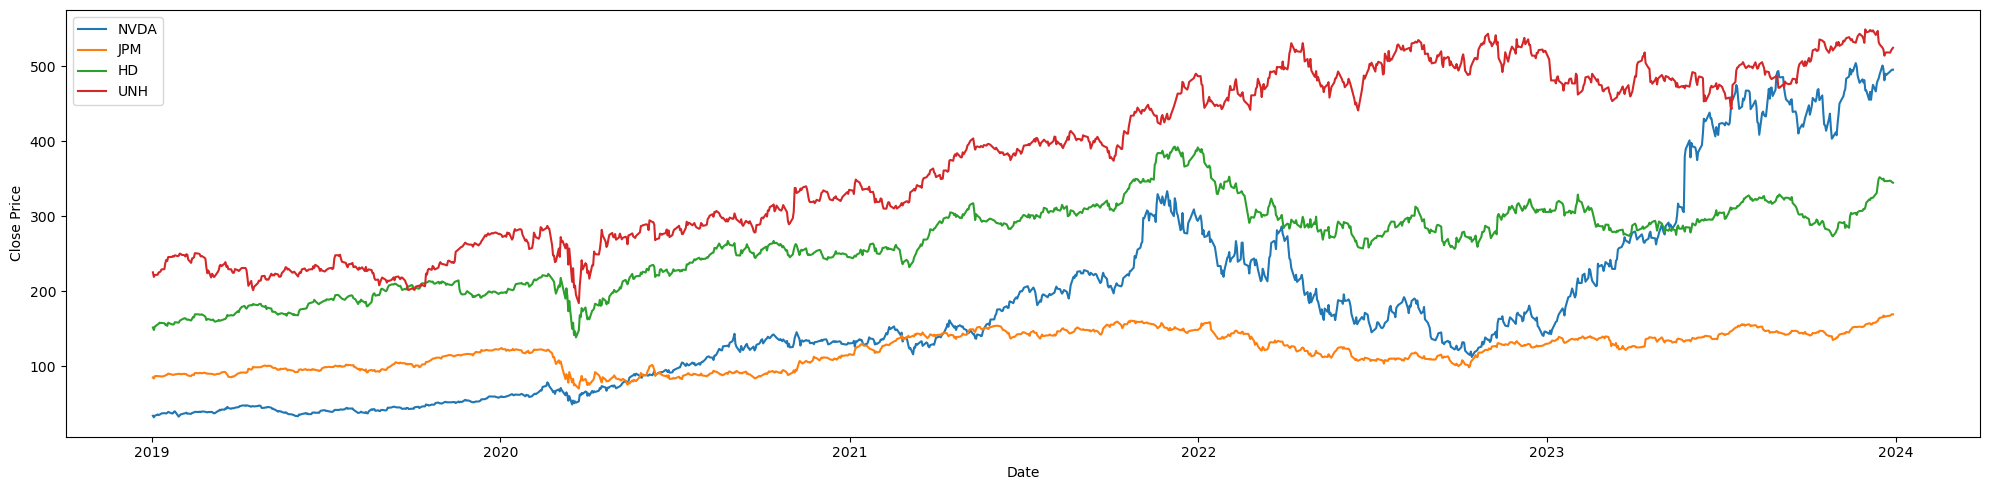

In [7]:
selected = ["nvda", "jpm", "hd", "unh"]
fig, ax = plt.subplots(1, 1, figsize=(20, 5))
for s in selected:
    df = load_processed_dataset(s, "2019-01-1", "2024-01-1")
    ax.plot(df.index, df['Close'], label=s.upper())
ax.set_xlabel('Date')
ax.set_ylabel('Close Price')
ax.legend()
fig.tight_layout()
plt.show()

We should not use price as our target variable. Firstly, it is non-stationary. We want our model to be time invariant. Secondly, can't extrapolate. 

We don't care about level information. If our goal is to profit, we only care about the direction of the stock. Hence, using percentage change or returns would be more suitable.

In fact, we use log returns, because ...

Still non-constant variance, we have volatilty clustering. Some models like GARCH aim to model this.

The same logic applies to using return instead of price as our inputs.

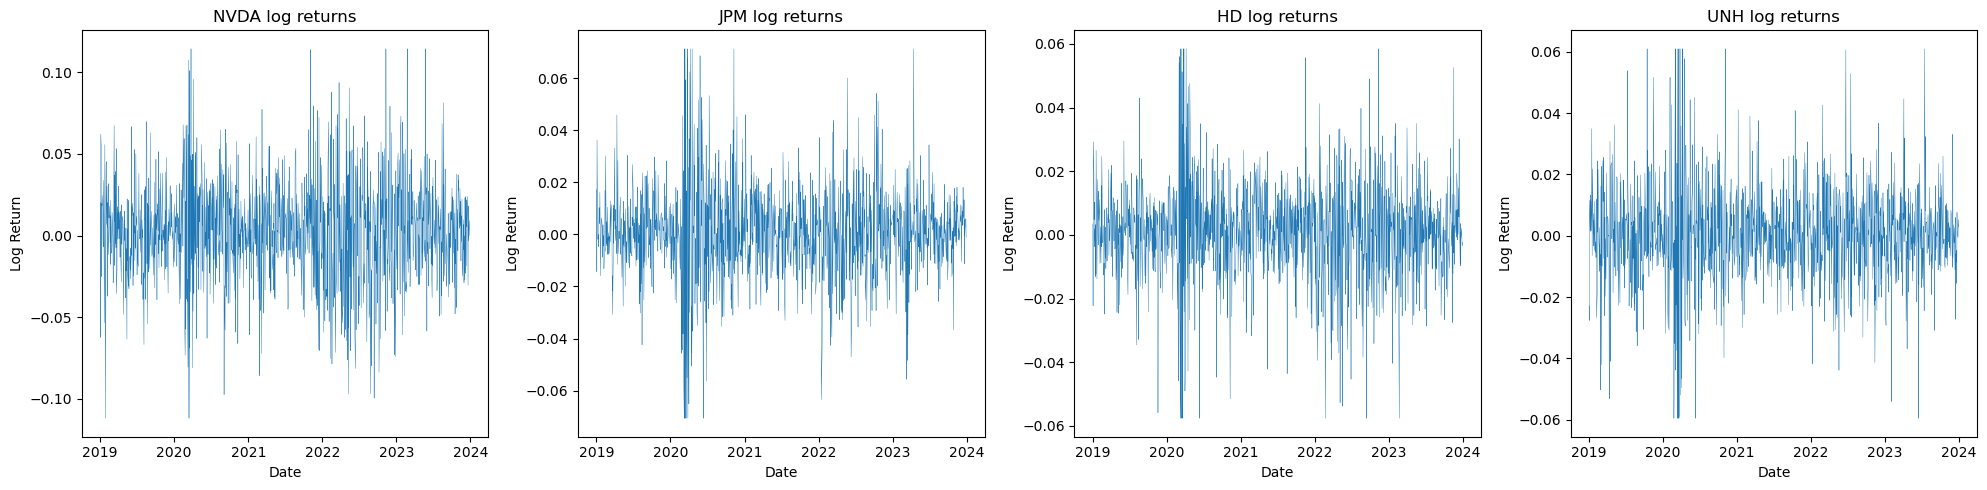

In [8]:
fig, axs = plt.subplots(1, 4, figsize=(20, 5)) 
for i, s in enumerate(selected):
    df = load_processed_dataset(s, "2019-01-1", "2024-01-1")
    axs[i].plot(df.index, df['log_return'], linewidth=0.3)
    axs[i].set_xlabel('Date')
    axs[i].set_ylabel('Log Return')
    axs[i].set_title(f"{s.upper()} log returns")
fig.tight_layout()
plt.show()

For normalisation, we choose Z-score normalisation (standardisation) over Min-Max. Since normalisation only fitted to the training data to prevent data leakage, using min max constrains values to the range of the train set, even though our test data might very well have values above those in the train set.

/Users/simon/anaconda3/envs/proj/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/Users/simon/anaconda3/envs/proj/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/Users/simon/anaconda3/envs/proj/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na op

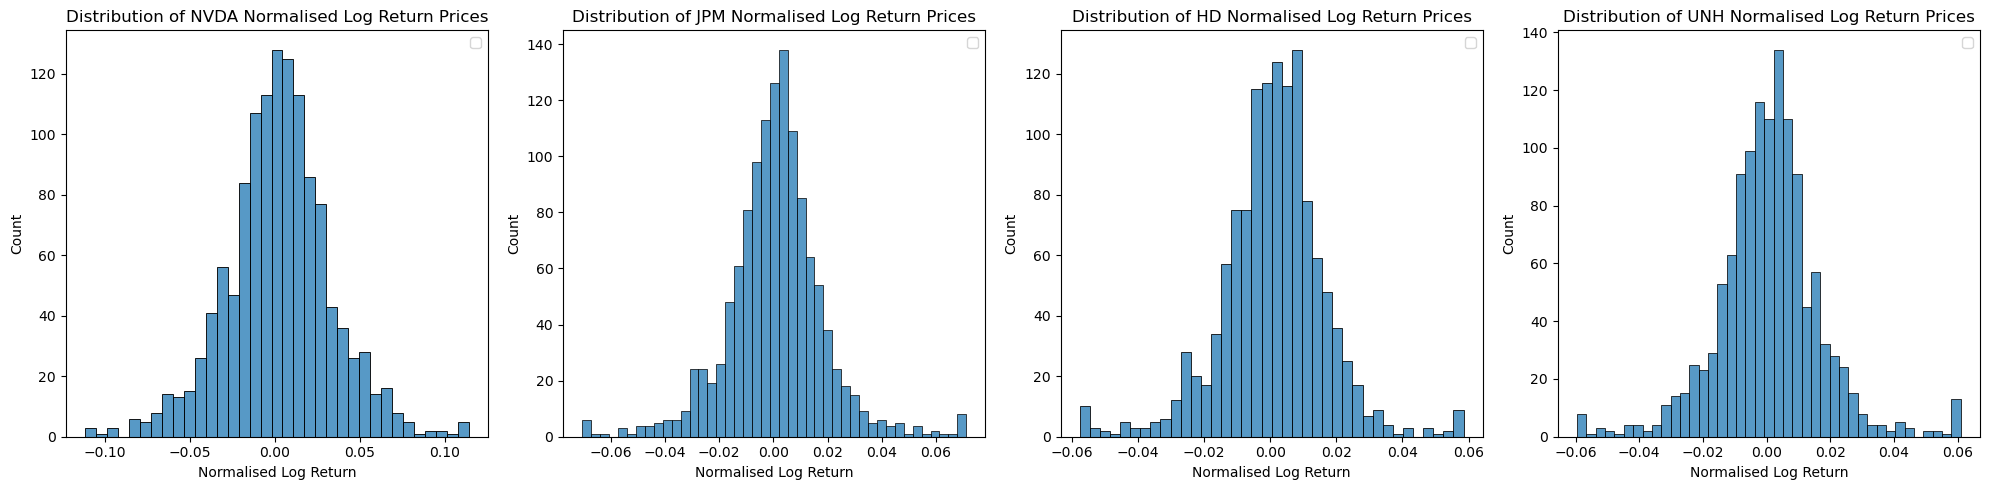

In [9]:
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm


fig, axs = plt.subplots(1, 4, figsize=(20, 5)) 
for i, s in enumerate(selected):
    df = load_processed_dataset(s, "2019-01-1", "2024-01-1")
    sns.histplot(df['log_return'], kde=False, ax=axs[i], stat="count")
    axs[i].set_title(f'Distribution of {s.upper()} Normalised Log Return Prices')
    axs[i].set_xlabel('Normalised Log Return')
    axs[i].legend()
fig.tight_layout()
plt.show()

Original std: 0.031207259952784967
Original std: 0.018032094710496185
Original std: 0.015860309675125958
Original std: 0.01636166888814389


/Users/simon/anaconda3/envs/proj/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/simon/anaconda3/envs/proj/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/simon/anaconda3/envs/proj/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/simon/anaconda3/envs/proj/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be

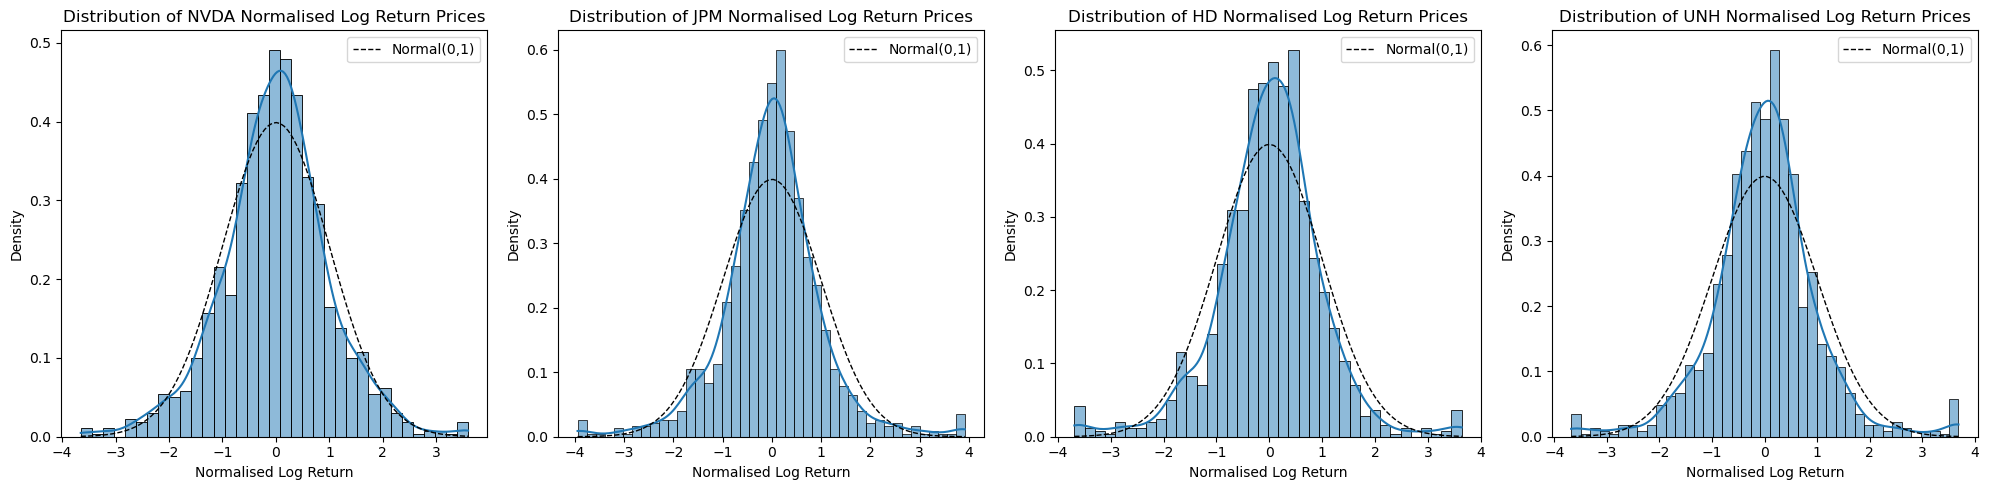

In [10]:
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm

fig, axs = plt.subplots(1, 4, figsize=(20, 5)) 
for i, s in enumerate(selected):
    df = load_processed_dataset(s, "2019-01-1", "2024-01-1")

    mean = df['log_return'].mean()
    std = df['log_return'].std()
    print(f"Original std: {std}")
    norm_log_return = (df['log_return'] - mean) / std
    # axs[i].hist(df['log_return'], bins=100, label=s)
    sns.histplot(norm_log_return, kde=True, ax=axs[i], stat="density")
    axs[i].set_title(f'Distribution of {s.upper()} Normalised Log Return Prices')
    axs[i].set_xlabel('Normalised Log Return')

    x = np.linspace(min(norm_log_return), max(norm_log_return), 100)
    p = stats.norm.pdf(x, 0, 1)
    axs[i].plot(x, p, 'k', linewidth=1, label=f'Normal(0,1)', linestyle="--")
    axs[i].legend()
fig.tight_layout()
plt.show()

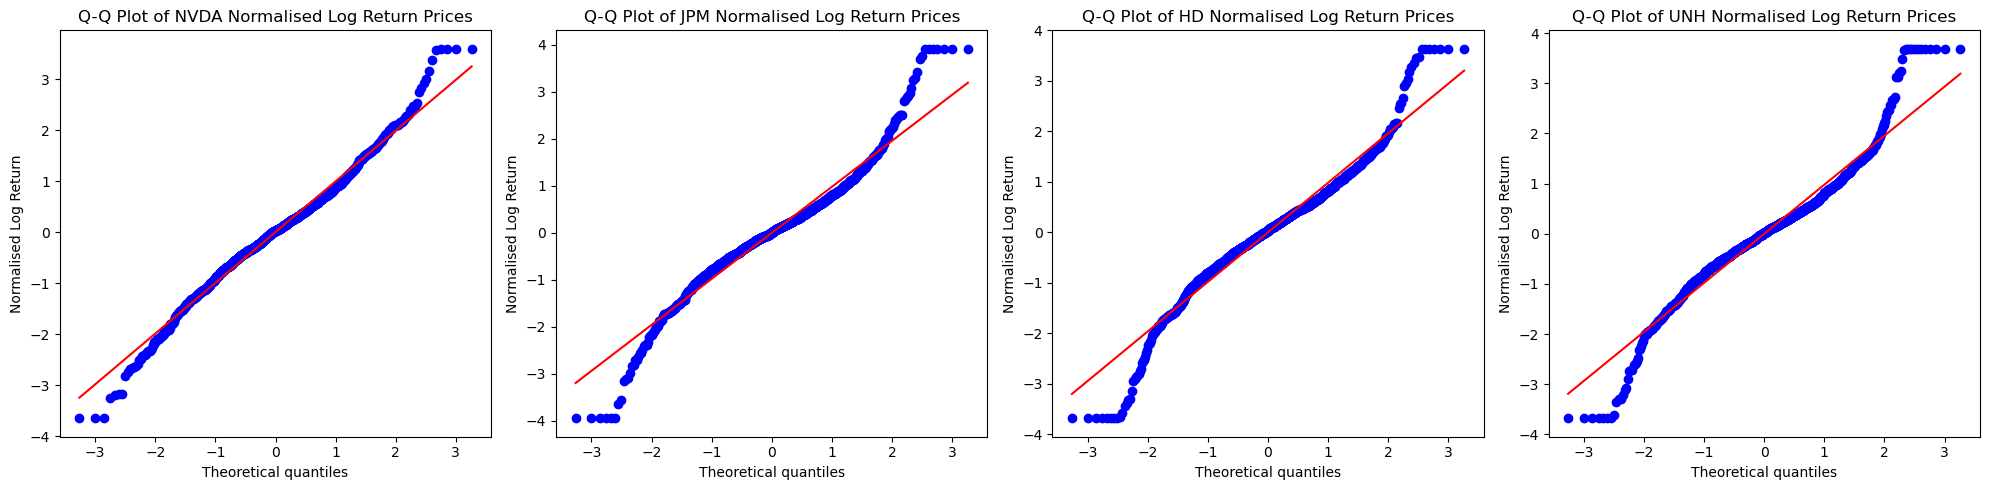

In [11]:
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm

fig, axs = plt.subplots(1, 4, figsize=(20, 5)) 
for i, s in enumerate(selected):
    df = load_processed_dataset(s, "2019-01-1", "2024-01-1")
    mean = df['log_return'].mean()
    std = df['log_return'].std()
    norm_log_return = (df['log_return'] - mean) / std
    # Q-Q plot
    stats.probplot(norm_log_return, dist="norm", plot=axs[i])
    axs[i].set_title(f'Q-Q Plot of {s.upper()} Normalised Log Return Prices')
    axs[i].set_ylabel('Normalised Log Return')
fig.tight_layout()
plt.show()

Although log return has many characterstics, being ...

It is not normally distributed. It has long tails. Using MSE loss means long tails will be penalised heavily much more than getting the middle of the distribution wrong. So our model will care about getting tail values rather than middle values. Therefore we use Huber loss because it is more lax on errors above a threshold. So we will set the threshold to 1, one standard deviation.

Carefully tuned SGD is better than Adam, so we use SGD. Also we use eight decay 1e-06.

Now we can look at R^2 metric to see if predictions are correlated.

Potential reasons for poor performance:
- Overfitting noisy data. Model finds mirage patterns.
- Not enough data. Trading minutes instead of days?
- Model does not have the right structure to extract insights.

KeyError: 'Dividends'

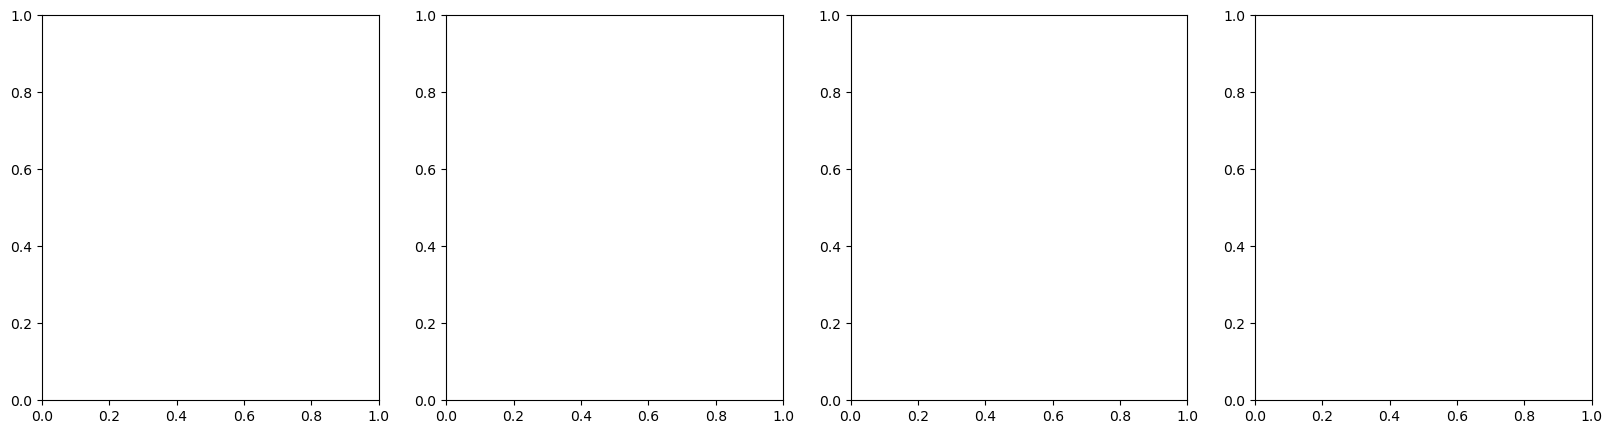

In [12]:
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm

fig, axs = plt.subplots(1, 4, figsize=(20, 5)) 
for i, s in enumerate(selected):
    df = load_processed_dataset(s, "2019-01-1", "2024-01-1")
    feature = "Dividends"
    axs[i].plot(df.index, df[feature], label=s, linewidth=0.3)
    axs[i].set_xlabel('Date')
    axs[i].set_ylabel(feature)
    axs[i].set_title(f"{s} log returns")
fig.tight_layout()
plt.show()

Now it is important to diagnose residuals. We would like to residuals to be uncorerelated and zero mean. If there is correlation between residuals, then there is information left in the residuals which can be used in computing the forecast. If the residuals have non-zero mean, then our forecasts are biased. Ideally, it woudld also be nice, but not necessary, to have constant variance and a normal distribution which make calculation of prediction intervals easier.

So residuals plot show whether our forecasts appear to account for all information. Talk about the
- Mean of residuals close to zero? (Histogram)
- Correlation in residuals series? (ACF)
- Variation of residuals constant? (Time series, histogram)
- Normal distribution (histogram) or tails too long? Even when ignoring outlioers? If not normal, confidence intervals computed assuming a normal distribution will be inaccurate.

A prediction interval gives an interval in which we expect $y_t$ to lie with a specified probability. A prediction interval for a $h$-step forecast is
$$
\hat{y}_{T+h}\pm c\hat\sigma_h
$$
where $c$ depends on the coverage probability, $\hat\sigma_h$ is the estimated standard deviation of the $h$-step forecast distribution.

For one-step ahead forecasts, the standard deviation of the forecast is almost the same as the standard deviation of the residuals. So if we have a prediction of 531.48, and the standard deviation of our residuals is 6.21, our 95% interval is 531.48$\pm$ 1.96(6.21), since we are assuming a normal distirbution, and 95% of the probability mass in a normal distribution falls within 1.96 standard deviations on either side of it.

However, if a normal distribution for forecast errors is an unreasonable assumption, we can use bootstrapping. We sample from the residuals and repeatedly simulate a set of future values. Then we calculate percentiles for each forecast horizon.

NB. if transformations has been used, the prediction interval should be computed on the transformed scale, and the end points inverse-transformed to give a prediction interval on the original scale. May not be symmetric around point forecast.

Linear regression assumptions:
- Relationship between target variable and predictor variable is a reasonable approximation to reality
- The errors:
    - have zero mean, otherwise forecasts will be systematically biased
    - not autocorrelated, otherwise inefficient forecasts as more information able ot be exlpoited
    - unrelated to the predictor variable, otherwise there is more information that could be included
Also useful to have nromally distributed, constant variance errors to easily produce prediction intervals.

fig, axs = plt.subplots(1, 4, figsize=(20, 5)) 
for i, s in enumerate(selected):
    df = load_processed_dataset(s, "2019-01-1", "2024-01-1")
    axs[i].plot(df.index, df['log_return'], linewidth=0.3)
    axs[i].set_xlabel('Date')
    axs[i].set_ylabel('Log Return')
    axs[i].set_title(f"{s.upper()} log returns")
fig.tight_layout()
plt.show()

Let' plot return against its forecast

NameError: name 'selected' is not defined

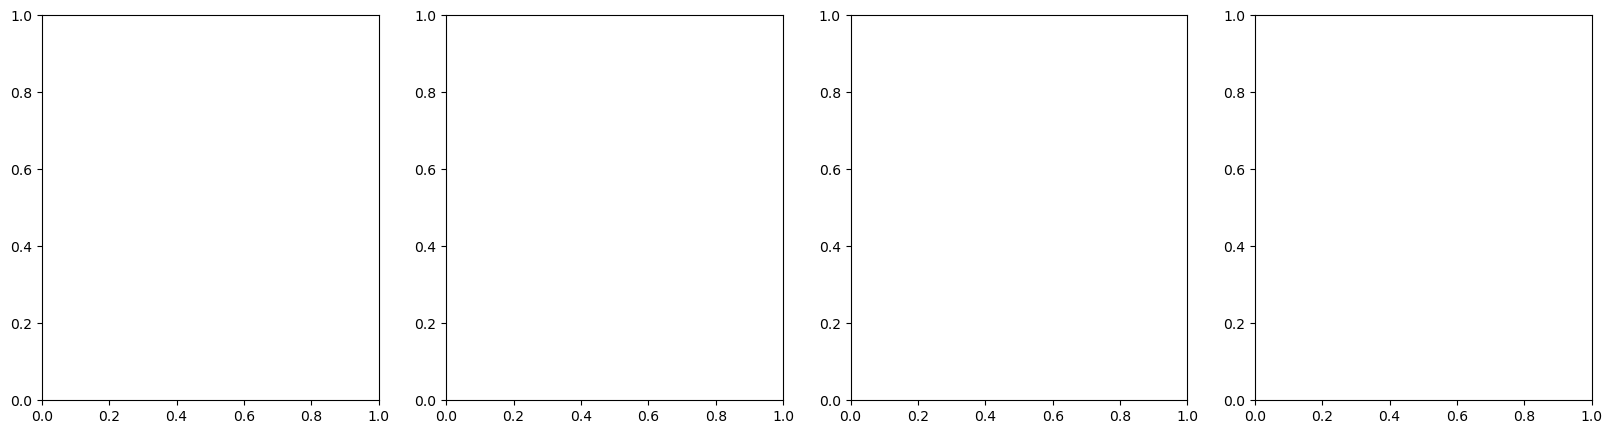

In [3]:
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm

fig, axs = plt.subplots(1, 4, figsize=(20, 5)) 
for i, s in enumerate(selected):
    df = load_processed_dataset(s, "2019-01-1", "2024-01-1")
    feature = "Dividends"
    axs[i].scatter(df["log_return"], df["log_return_forecast"], label=s, linewidth=0.3)
    # axs[i].set_xlabel('Date')
    # axs[i].set_ylabel(feature)
    # axs[i].set_title(f"{s} log returns")
    x = np.linspace(start=df["log_return"].min(), stop=df["log_return"].max(), num=100)
    y = np.zeros(len(x))
    axs[i].plot(x, y)
fig.tight_layout()
plt.show()

In [18]:
import seaborn as sns
import pandas as pd
import numpy as np

np.random.seed(42)

df = load_processed_dataset("nvda", "2004-01-1", "2024-01-1").sample(1000)
features = [ 'log_return',
       'log_return_open', 'log_return_high', 'log_return_low',
       'log_return_volume', 'log_return_forecast', 'sma', 'wma', 'ema', 'dema',
       'tema', 'aroon', 'rsi', 'willr', 'cci', 'ad', 'mom', 'slowk', 'slowd',
       'macd', 'fed_funds_rate', '^N225', '^IXIC', '^FTSE', '^SPX', '^DJI']

/Users/simon/anaconda3/envs/proj/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/simon/anaconda3/envs/proj/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/simon/anaconda3/envs/proj/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/simon/anaconda3/envs/proj/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be

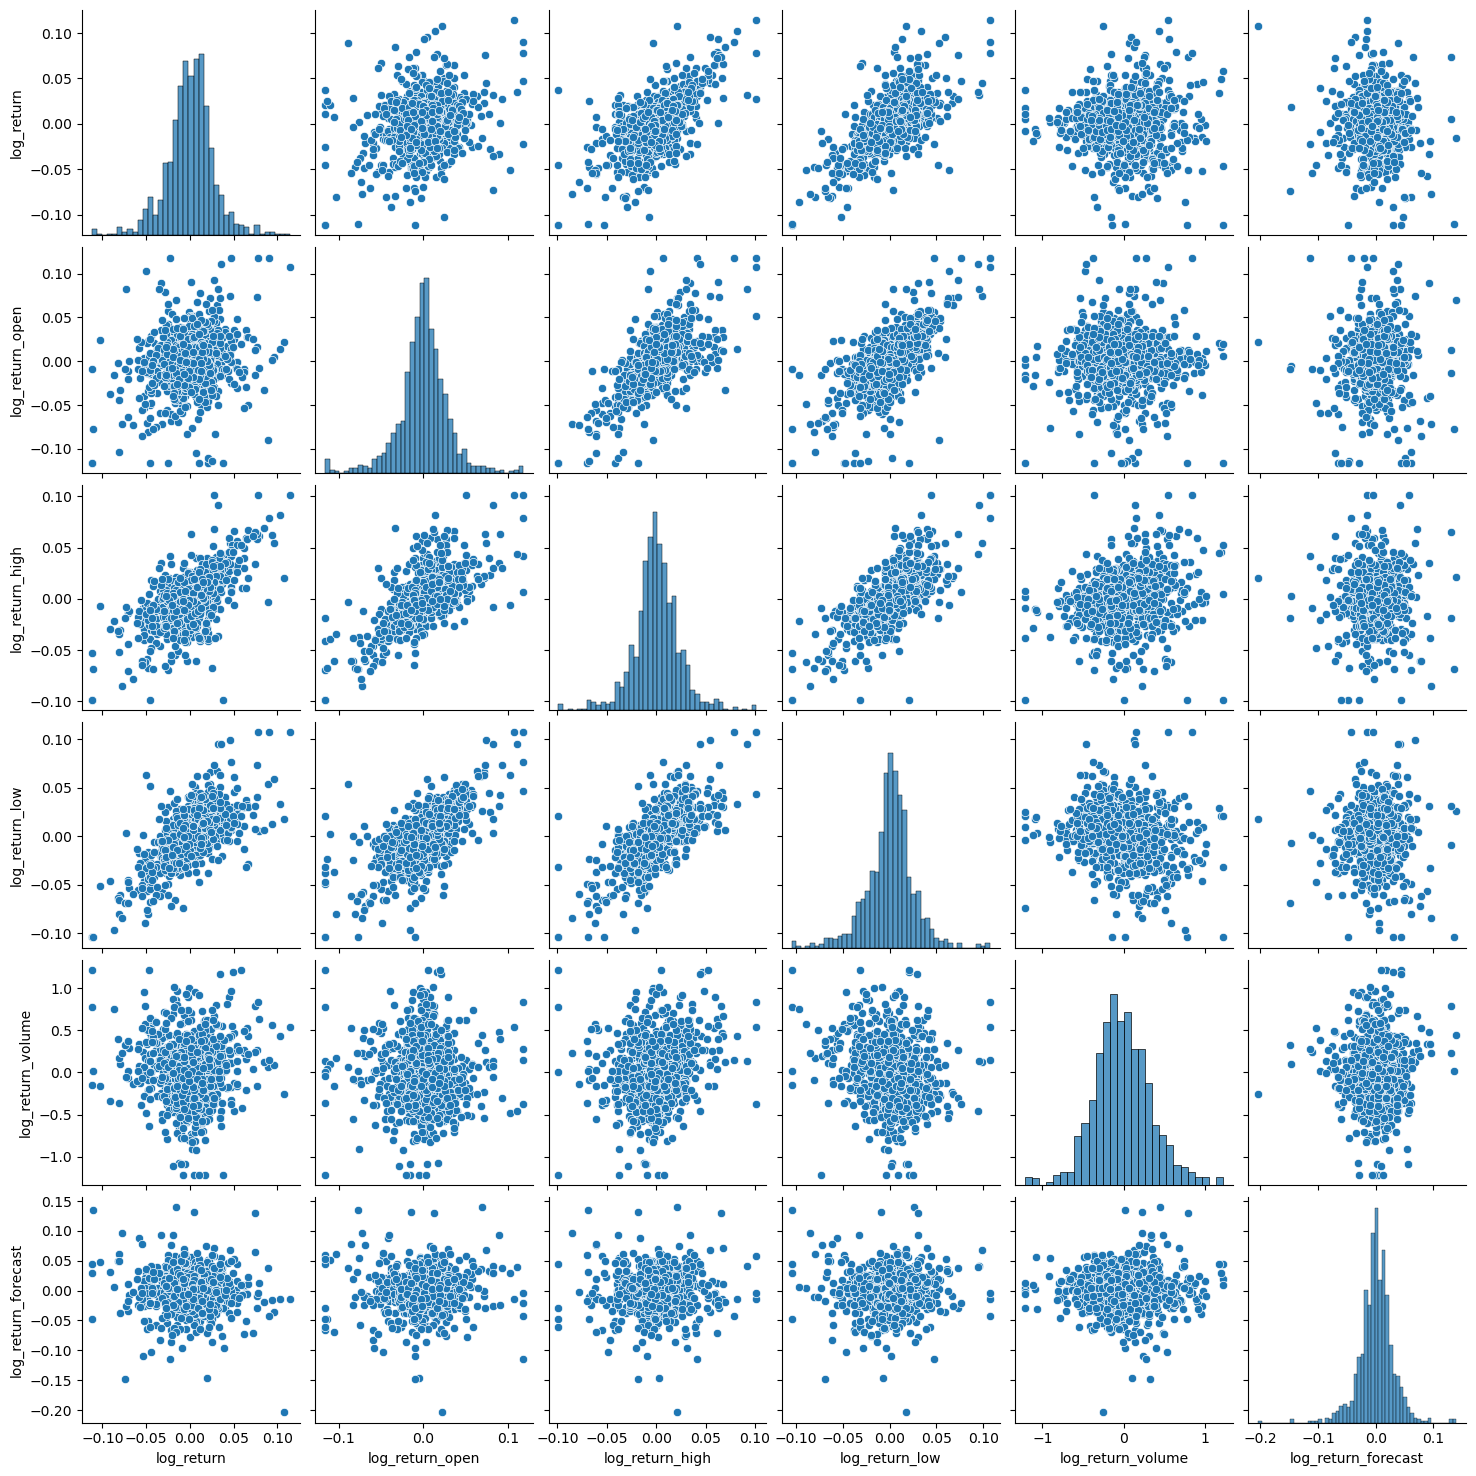

In [13]:
features = ['log_return_forecast',
       'log_return_open', 'log_return_high', 'log_return_low',
       'log_return', 'log_returnm_volume']
_ = sns.pairplot(df[features], kind="scatter", diag_kind="hist")

/Users/simon/anaconda3/envs/proj/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/simon/anaconda3/envs/proj/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/simon/anaconda3/envs/proj/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/simon/anaconda3/envs/proj/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be

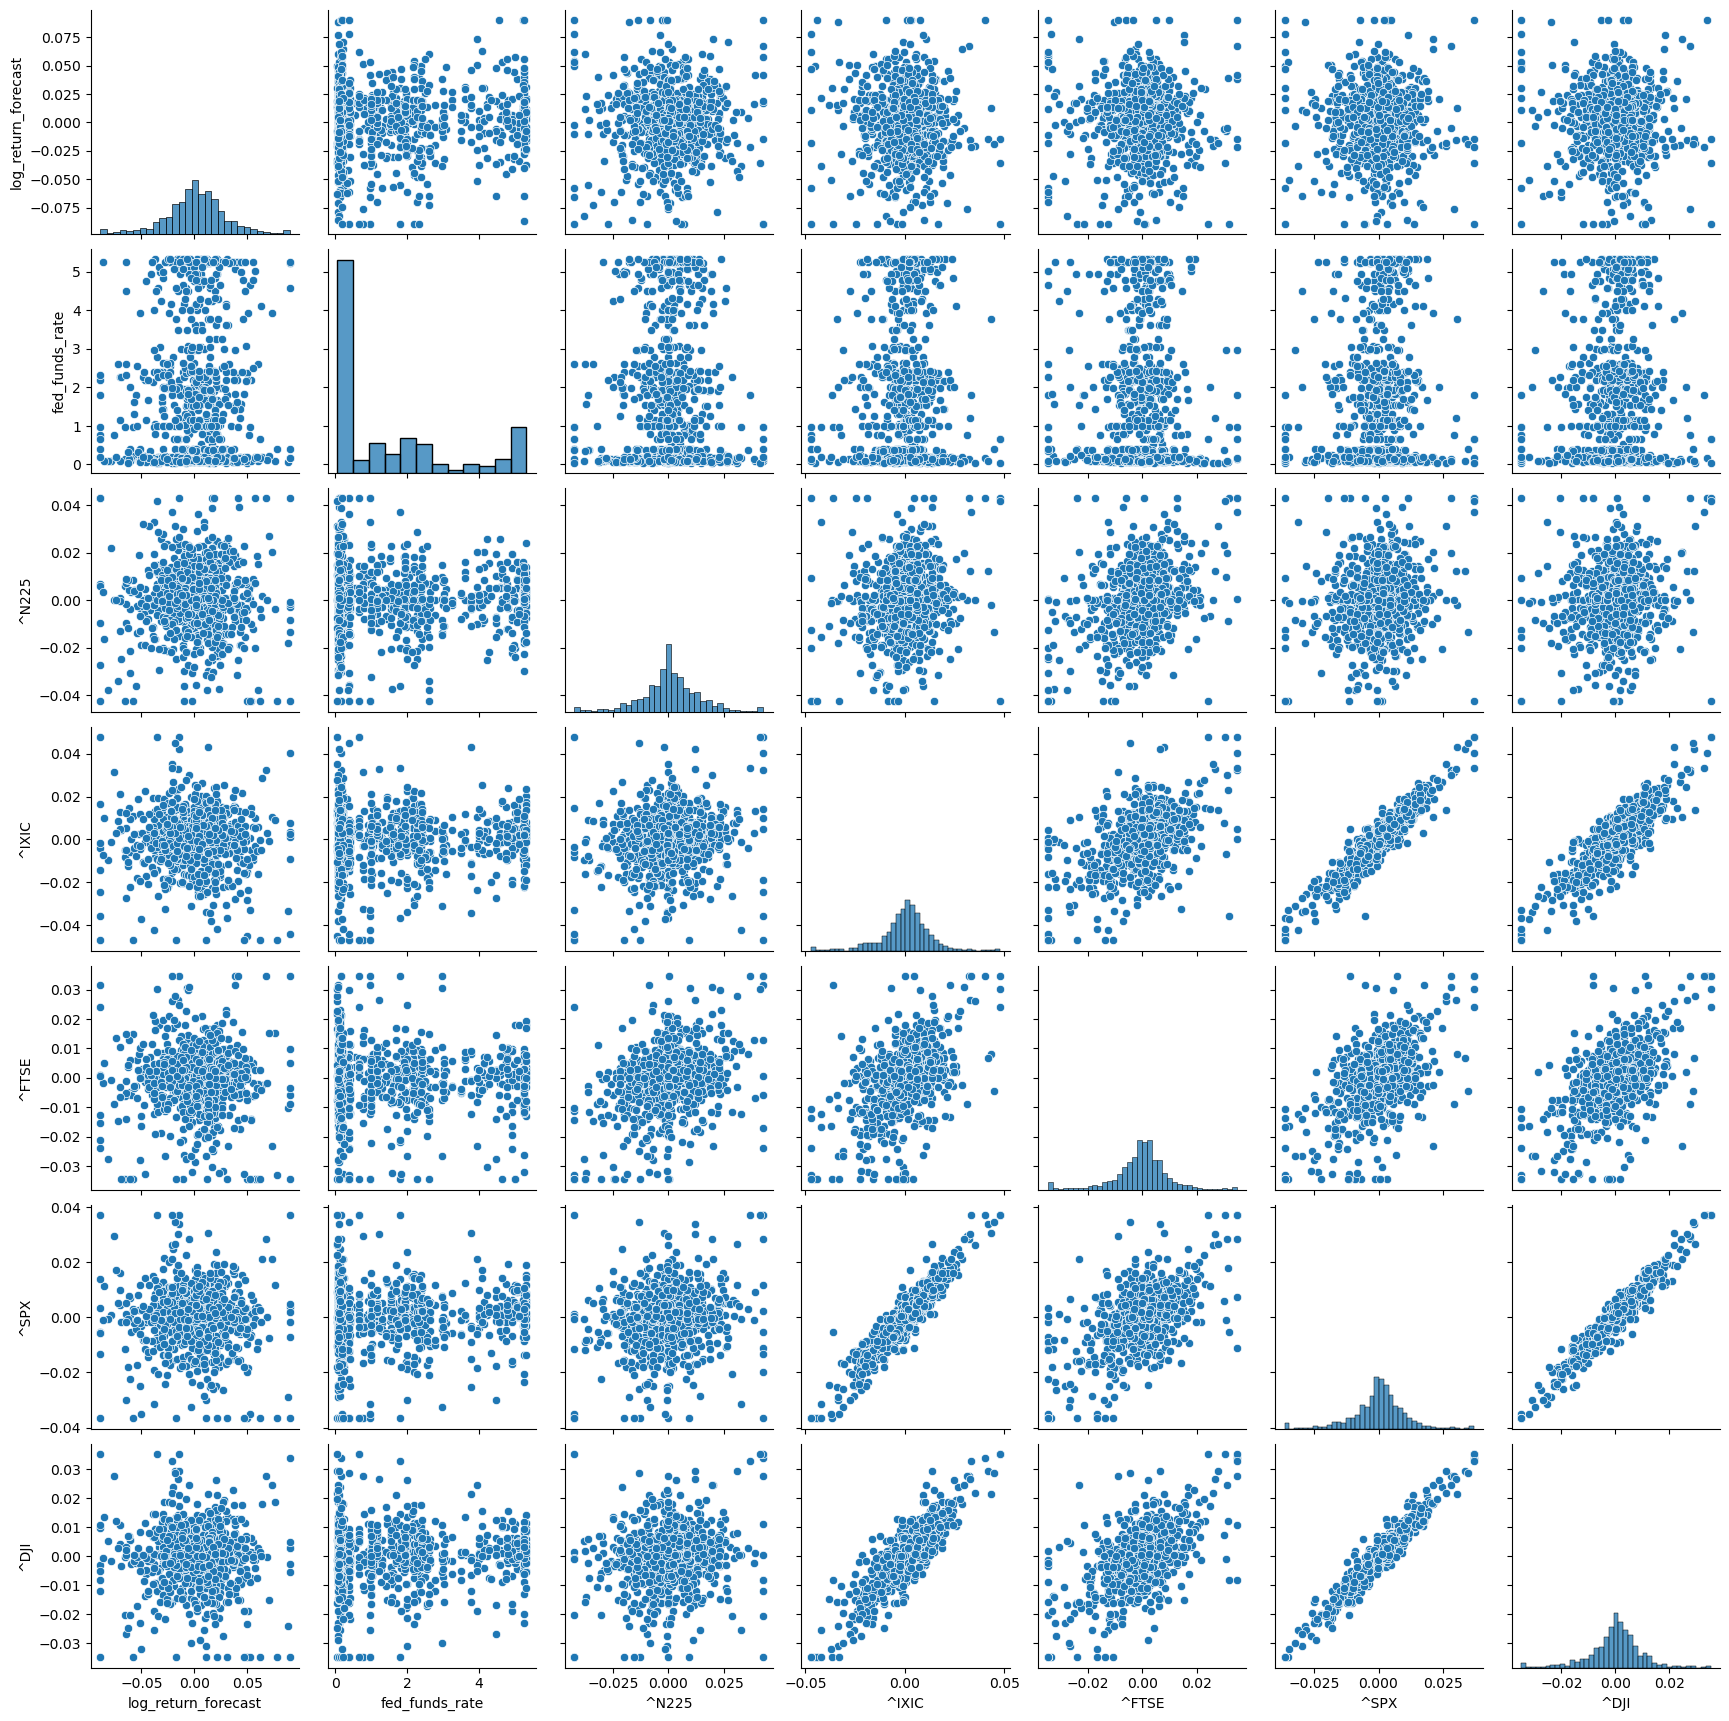

In [20]:
features = ['log_return_forecast', 'fed_funds_rate', '^N225', '^IXIC', '^FTSE', '^SPX', '^DJI']
from src.data.assess import treat_outliers
df["log_return_forecast"] = treat_outliers(df["log_return_forecast"])
_ = sns.pairplot(df[features], kind="scatter", diag_kind="hist")